원본 커널 : https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

In [4]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold
# from sklearn.cross_validation import KFold

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

PassengerID = test['PassengerId']

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<br>

### Feature Engineering

In [6]:
full_data = [train, test]

train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# Feature that tells whether a passenger had a cabin on the Titanic

train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
# train.Cabin[0] == Nan == type()이 float
# 나머지 type 은 str , 즉 nan는 0 으로 it doesn't have cabin 

In [7]:
type(train.Cabin[1]) , type(train.Cabin[0])

(str, float)

In [8]:
# FamilySize = SibSp + Parch
for dataset in full_data :
    dataset["FamilySize"] = dataset['SibSp'] +dataset['Parch'] + 1
    
for dataset in full_data:
    dataset["IsAlone"] = 0
    dataset.loc[dataset['FamilySize'] ==1, 'IsAlone'] = 1

In [9]:
dataset.Embarked.value_counts()

S    270
C    102
Q     46
Name: Embarked, dtype: int64

In [10]:
# Embarked Null
for dataset in full_data: # Embarked 최빈값 S
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [11]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
train['CategoricalFare'].head()

0     (-0.001, 7.91]
1    (31.0, 512.329]
2     (7.91, 14.454]
3    (31.0, 512.329]
4     (7.91, 14.454]
Name: CategoricalFare, dtype: category
Categories (4, interval[float64]): [(-0.001, 7.91] < (7.91, 14.454] < (14.454, 31.0] < (31.0, 512.329]]

In [12]:
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg+age_std, size=age_null_count)
    # np.random_randit(low, high, size)
    
    dataset['Age'][np.isnan(dataset["Age"])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
train['CategoricalAge'] = pd.qcut(train['Age'], 5)
train['CategoricalAge'].head()

0    (19.0, 25.0]
1    (32.0, 40.0]
2    (25.0, 32.0]
3    (32.0, 40.0]
4    (32.0, 40.0]
Name: CategoricalAge, dtype: category
Categories (5, interval[float64]): [(-0.001, 19.0] < (19.0, 25.0] < (25.0, 32.0] < (32.0, 40.0] < (40.0, 80.0]]

In [13]:
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.', name)
    # 정규방정식 영어 1개 이상 그다음에 . 있는 것 뽑아내기
    
    if title_search:
        return title_search.group(1)
    return ''

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# Group all non-common titles into one single grouping 'Rare'
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major',
                                                'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [14]:
for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map( {'female':0, 'male':1}).astype(int)
    
    title_mapping = {"Mr":1, "Miss":2, "Mrs":3, 'Master':4, 'Rare':5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q':2}).astype(int)
    
    #Mapping Fare
    dataset.loc[dataset['Fare'] <= 7.91, "Fare"] = 0
    dataset.loc[(dataset['Fare']> 7.91) & (dataset["Fare"] <= 14.454), 'Fare'] =1
    dataset.loc[(dataset['Fare']> 14.454) & (dataset["Fare"] <= 31), 'Fare'] =2
    dataset.loc[dataset['Fare']> 31, 'Fare'] =3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    #Mapping Age
    dataset.loc[dataset['Age']<=16, 'Age'] = 0
    dataset.loc[(dataset['Age']>16) &(dataset['Age'] <=32), 'Age'] = 1
    dataset.loc[(dataset['Age']>32) &(dataset['Age'] <=48), 'Age'] = 2
    dataset.loc[(dataset['Age']>48) &(dataset['Age'] <=64), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 64), 'Age'] =4

<br>

### Feature selection

In [15]:
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']

train = train.drop(drop_cols, axis=1)
train = train.drop( ['CategoricalAge', 'CategoricalFare'], axis=1)

test = test.drop(drop_cols, axis=1)

In [16]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1


<br>

### Visualizations

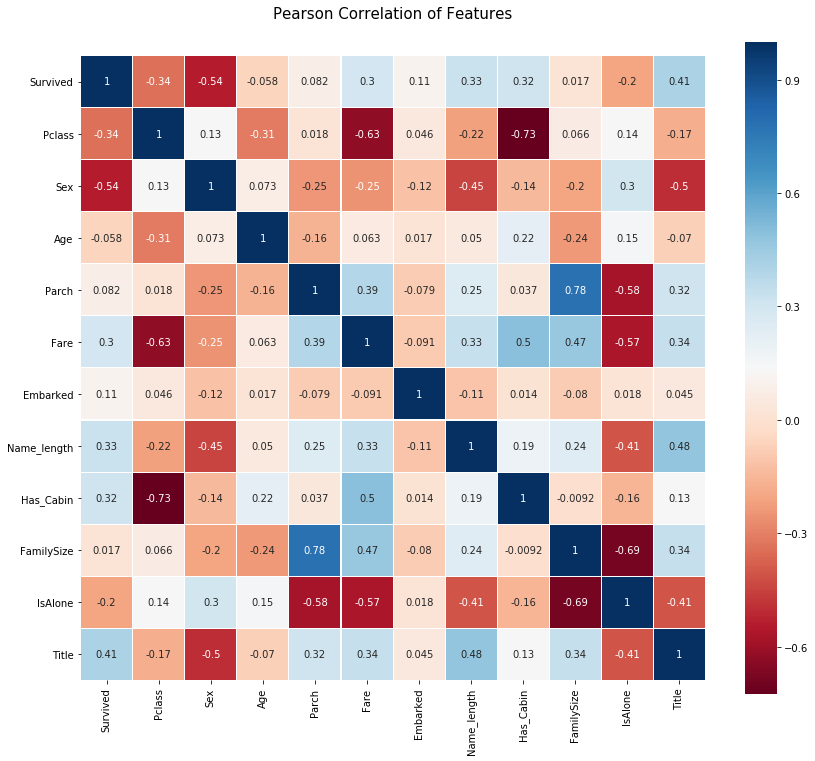

In [17]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square = True, cmap=colormap, linecolor='white', annot=True)

<br>

#### Pariplots

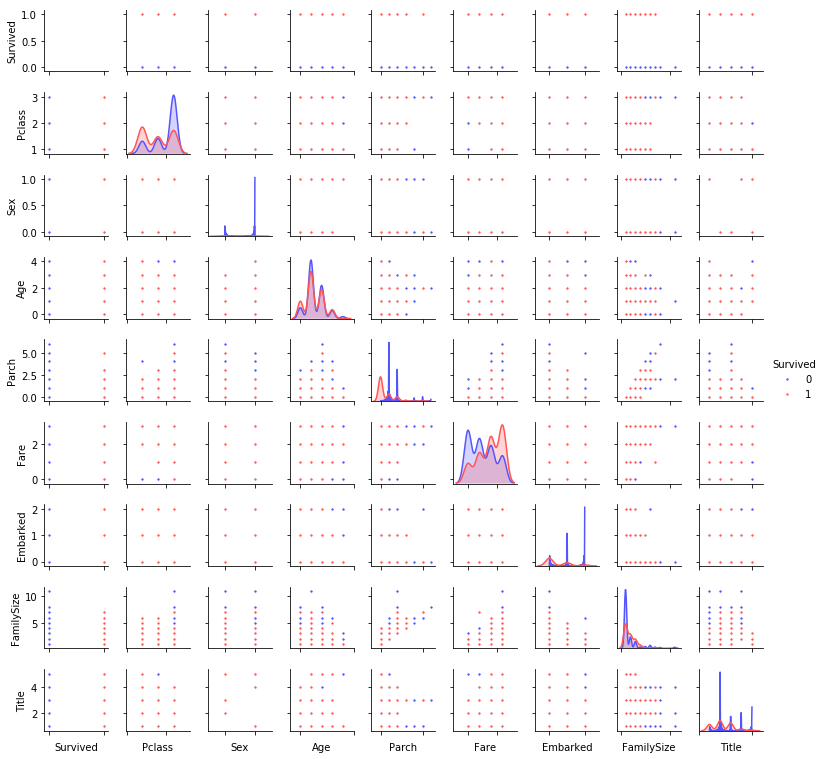

In [18]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
                       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic', size=1.2, diag_kind='kde',
                diag_kws = dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

In [19]:
train[[u'Survived']].head()

# u 의 의미는????

,Survived
0,0
1,1
2,1
3,1
4,0


<br>

### Ensembling & Stacking models

In [20]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits = NFOLDS, random_state = SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

<br>

### Out-of-Fold Predictions


In [21]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain, ))
    oof_test = np.zeros((ntest, ))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr) # SklearnHelper 클래스 내 함수
        
        oof_train[test_index] = clf.predict(x_te)
        
        oof_test_skf[i, :] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1,1)

<br>

### Generating our Base First-Level Moels
1. Random Forest classifier
2. Extra Trees Classifier
3. AdaBoost Boosting classifer
4. Gradient Boosting Classifer
5. Support Vector Machines

<br>

#### Parameters
- `n_jobs` : train 과정에서 사용되는 cores #, If set to -1, all cores are used.
- `n_estimatros` : classification trees #
- `verbose` : Controls whether you want to output any text during the learning process

In [22]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start':True,
    'max_depth': 6,
    'min_samples_leaf':2,
    'max_features':'sqrt',
    'verbose':0
} # 특성 + 데이터 랜덤 추출


et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_samples_leaf':2,
    'verbose':0
}


ada_params = {
    'n_estimators': 500,
    'learning_rate':0.75
} # 잘못 분류된 것에 가중치 부여

gb_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_leaf':2,
    'verbose':0
} # 학습된 모델의 residual error 에 가중치 부여

svc_params = {
    'kernel':'linear',
    'C' : 0.025
}

In [23]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [24]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [25]:
x_train

array([[3, 1, 1, ..., 2, 0, 1],
       [1, 0, 2, ..., 2, 0, 3],
       [3, 0, 1, ..., 1, 1, 2],
       ...,
       [3, 0, 1, ..., 4, 0, 2],
       [1, 1, 1, ..., 1, 1, 1],
       [3, 1, 1, ..., 1, 1, 1]], dtype=int64)

In [26]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


In [ ]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.12499117 0.19868108 0.03287259 0.02163435 0.07141757 0.02347602
 0.10892664 0.06574745 0.06595452 0.01363935 0.27265926]
[0.12042065 0.37739445 0.03027968 0.01648124 0.05560442 0.02883921
 0.04788052 0.08336285 0.04558473 0.02124847 0.17290378]
[0.028 0.012 0.018 0.066 0.036 0.008 0.696 0.012 0.05  0.006 0.068]
[0.08594584 0.00967828 0.05768589 0.01140975 0.04626359 0.02275277
 0.17547589 0.03809106 0.1146984  0.0072896  0.43070895]


In [ ]:
rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371
  ,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [ 0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157
  ,0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008
  ,0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
gb_features = [ 0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854
  ,0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]

In [ ]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [ ]:
cols

array(['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'Name_length',
       'Has_Cabin', 'FamilySize', 'IsAlone', 'Title'], dtype=object)

In [ ]:
# Random Forest
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Sex, FamilySize

In [ ]:
# Extra Trees
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')
# Sex

In [ ]:
# Adaboost
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')
# IsAlone

In [ ]:
# Gradient boosting
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')
# IsAlone

In [ ]:
feature_dataframe['mean'] = feature_dataframe.mean(axis=1)
feature_dataframe.head()

In [ ]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [ ]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
                                       'ExtraTrees': et_oof_train.ravel(),
                                       'AdaBoost':ada_oof_train.ravel(),
                                       'GradientBoost':gb_oof_train.ravel()})

base_predictions_train.head()

In [ ]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [ ]:
# 배열 병합
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [ ]:
x_train

In [ ]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)

predictions = gbm.predict(x_test)

In [ ]:
StackingSubmission = pd.DataFrame({'PassengerId':PassengerID, 'Survived':predictions})
StackingSubmission.to_csv('StackingSubmission.csv', index=False)

In [ ]:
gbm